Here is a Python code implementation to run the numerical experiments for comparing the performance of QHM, NAG, and SHB momentum methods using stochastic gradient descent (SGD). This example uses common libraries such as numpy, scikit-learn, and matplotlib to evaluate performance on the MNIST and CIFAR dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.special import expit  # Sigmoid function for logistic regression

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical




class QHM_empirical_analysis:
    
    dataset = None
    X, y = None, None
    X_train, X_test, y_train, y_test = None, None, None, None
    
    scaler = StandardScaler()

    def __init__(self,DATASET: str):
        
        if DATASET in ['CIFAR-10','MNIST_784']:
            self.dataset = DATASET
            self.initialize_data()
        
        else:
            raise ValueError("Invalid input: string must be either 'CIFAR-10' or 'MNIST_784'.")
    
    
    def initialize_data(self):
        
        if self.dataset == 'CIFAR-10':

            # Load CIFAR-10 dataset and prepare binary classification (e.g., classifying between "airplane" and "automobile")
            (self.X_train_full, self.y_train_full), (self.X_test_full, self.y_test_full) = cifar10.load_data()

            # Select only classes "airplane" (0) and "automobile" (1) for binary classification
            class_0, class_1 = 0, 1
            self.X_train = self.X_train_full[(self.y_train_full.flatten() == class_0) | (self.y_train_full.flatten() == class_1)]
            self.y_train = self.y_train_full[(self.y_train_full.flatten() == class_0) | (self.y_train_full.flatten() == class_1)]
            self.y_train = (self.y_train.flatten() == class_1).astype(int)

            self.X_test = self.X_test_full[(self.y_test_full.flatten() == class_0) | (self.y_test_full.flatten() == class_1)]
            self.y_test = self.y_test_full[(self.y_test_full.flatten() == class_0) | (self.y_test_full.flatten() == class_1)]
            self.y_test = (self.y_test.flatten() == class_1).astype(int)

            # Flatten images and scale pixel values
            self.X_train = self.X_train.reshape(self.X_train.shape[0], -1) / 255.0
            self.X_test = self.X_test.reshape(self.X_test.shape[0], -1) / 255.0
        
        if self.dataset == 'MNIST_784':
            # Load MNIST dataset
            mnist = fetch_openml('mnist_784')
            self.X = mnist.data / 255.0  # Normalizing pixel values
            self.y = mnist.target.astype(int)

            # Convert target to binary classification (digits 0 vs 1)
            self.X = self.X[(self.y == 0) | (self.y == 1)]
            self.y = self.y[(self.y == 0) | (self.y == 1)]

            # Split data into training and test sets
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
            
        
        # Standardize the data
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

    
    # Sigmoid function for binary classification
    def sigmoid(self,z):
        return expit(z)

    # Loss function (Binary Cross-Entropy)
    def binary_cross_entropy(self,y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))

    # Gradient of the loss function
    def gradient(self,X, y_true, y_pred):
        return np.dot(X.T, (y_pred - y_true)) / len(y_true)

    # Momentum methods

    # 1. Stochastic Heavy Ball (SHB)
    def shb_sgd(self,X, y, alpha=0.01, beta=0.9, num_iterations=1000):
        weights = np.zeros(X.shape[1])
        momentum = np.zeros(X.shape[1])
        loss_history = []

        for i in range(num_iterations):
            y_pred = self.sigmoid(np.dot(X, weights))
            grad = self.gradient(X, y, y_pred)
        
            momentum = beta * momentum + (1 - beta) * grad
            weights -= alpha * momentum
        
            # Record loss
            loss = self.binary_cross_entropy(y, y_pred)
            loss_history.append(loss)

        return weights, loss_history

    # 2. Nesterov's Accelerated Gradient (NAG)
    def nag_sgd(self,X, y, alpha=0.01, beta=0.9, num_iterations=1000):
        weights = np.zeros(X.shape[1])
        momentum = np.zeros(X.shape[1])
        loss_history = []

        for i in range(num_iterations):
            #lookahead_weights = weights - beta * momentum
            lookahead_weights = weights - beta * alpha * momentum
            
            y_pred = self.sigmoid(np.dot(X, lookahead_weights))
            grad = self.gradient(X, y, y_pred)
            
            #momentum = beta * momentum + alpha * grad
            momentum = beta * momentum + grad
            weights -= alpha * momentum
            
            # Record loss
            loss = self.binary_cross_entropy(y, y_pred)
            loss_history.append(loss)

        return weights, loss_history

    # 3. Quasi-Hyperbolic Momentum (QHM)
    def qhm_sgd(self,X, y, alpha=0.01, beta=0.9, nu=0.7, num_iterations=1000):
        weights = np.zeros(X.shape[1])
        momentum = np.zeros(X.shape[1])
        loss_history = []

        for i in range(num_iterations):
            y_pred = self.sigmoid(np.dot(X, weights))
            grad = self.gradient(X, y, y_pred)
            
            momentum = beta * momentum + (1 - beta) * grad
            weights -= alpha * ((1 - nu) * grad + nu * momentum)
            
            # Record loss
            loss = self.binary_cross_entropy(y, y_pred)
            loss_history.append(loss)

        return weights, loss_history

    # Evaluate performance on the test set

    def evaluate_model(self,weights, X_test, y_test):
        y_pred = self.sigmoid(np.dot(X_test, weights))
        y_pred_labels = (y_pred >= 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred_labels)
        return accuracy

    # Experiment setup

    def run_experiment1(self,num_iterations=250,alpha=0.01):
        print('Running experiments...')
        
        # beta = 0.3
        _1, betap3_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.3, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.5
        _2, betap5_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.5, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.7
        _3, betap7_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta = 0.7, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.9, nu = 0.5
        _4, betap9_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.9, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.99, nu = 0.5
        _5, betap99_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.99, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.999, nu = 0.5
        _6, betap999_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.999, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.9, nu = 0.95
        _7, betap9_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.9, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.99, nu = 0.95
        _8, betap99_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.99, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.999, nu = 0.95
        _9, betap999_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.999, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.001, nu = 0.5
        _10, betap001_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.001, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.01, nu = 0.5
        _11, betap01_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.01, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.1, nu = 0.5
        _12, betap1_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.1, nu=0.5, num_iterations=num_iterations)
        
        # beta = 0.001, nu = 0.95
        _13, betap001_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.001, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.01, nu = 0.95
        _14, betap01_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.01, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.1, nu  = 0.95
        _15, betap1_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.1, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.3
        _16, betap3_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.3, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.5
        _17, betap5_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=0.5, nu=0.95, num_iterations=num_iterations)
        
        # beta = 0.7
        _18, betap7_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta = 0.7, nu=0.95, num_iterations=num_iterations)
        
        A1,A2,A3 = round(self.evaluate_model(weights=_1,X_test=self.X_test,y_test=self.y_test),4,), round(self.evaluate_model(weights=_2,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_3,X_test=self.X_test,y_test=self.y_test),4)
        B1,B2,B3= round(self.evaluate_model(weights=_16,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_17,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_18,X_test=self.X_test,y_test=self.y_test),4)
        C1,C2,C3= round(self.evaluate_model(weights=_4,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_5,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_6,X_test=self.X_test,y_test=self.y_test),4)
        D1,D2,D3 = round(self.evaluate_model(weights=_7,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_8,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_9,X_test=self.X_test,y_test=self.y_test),4)
        E1,E2,E3 = round(self.evaluate_model(weights=_10,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_11,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_12,X_test=self.X_test,y_test=self.y_test),4)
        F1,F2,F3 = round(self.evaluate_model(weights=_13,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_14,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_15,X_test=self.X_test,y_test=self.y_test),4)
    
        fig, axs = plt.subplots(3,2)
        fig.suptitle("QHM Loss on " + str(self.dataset) + " with Varying Levels of β, ν (250 Iterations)")
        
        axs[0,0].plot(betap3_loss_history, label="β = 0.3")
        axs[0,0].plot(betap5_loss_history, label="β = 0.5")
        axs[0,0].plot(betap7_loss_history, label="β = 0.7")
        axs[0,0].set_title("A: β near '0.5', ν= 0.5, α = 0.01")
        
        axs[0,1].plot(betap3_loss_history2, label="β = 0.3")
        axs[0,1].plot(betap5_loss_history2, label="β = 0.5")
        axs[0,1].plot(betap7_loss_history2, label="β = 0.7")
        axs[0,1].set_title("B: β near '0.5', ν= 0.95, α = 0.01")
        
        axs[1,0].plot(betap9_loss_history, label="β = 0.95")
        axs[1,0].plot(betap99_loss_history, label="β = 0.99")
        axs[1,0].plot(betap999_loss_history, label="β = 0.999")
        axs[1,0].set_title("C: β near '1', ν= 0.5, α = 0.01")
        
        axs[1,1].plot(betap9_loss_history2, label="β = 0.95")
        axs[1,1].plot(betap99_loss_history2, label="β = 0.99")
        axs[1,1].plot(betap999_loss_history2, label="β = 0.999")
        axs[1,1].set_title("D: β near '1', ν = 0.95, α = 0.01")
        
        axs[2,0].plot(betap001_loss_history, label="β = 0.001")
        axs[2,0].plot(betap01_loss_history, label="β = 0.01")
        axs[2,0].plot(betap1_loss_history, label="β = 0.1")
        axs[2,0].set_title("E: β near '0', ν = 0.5, α = 0.01")
        
        axs[2,1].plot(betap001_loss_history2, label="β = 0.001")
        axs[2,1].plot(betap01_loss_history2, label="β = 0.01")
        axs[2,1].plot(betap1_loss_history2, label="β = 0.1")
        axs[2,1].set_title("F: β near '0', ν = 0.95, α = 0.01")

        for ax in axs.flat:
            ax.set(xlabel='Iterations',ylabel='Loss')
            ax.grid(True)
            ax.legend()
            
        for ax in axs.flat:
            ax.label_outer()
            
        fig2, ax = plt.subplots()
        
        fig2.patch.set_visible(False)
        #fig2.suptitle("Accuracy scores for Figure 1 - 'MNIST_784")
        ax.axis('off')
        #ax.axis('tight')
        
        data = {'A': [A1,A2,A3], 'B': [B1,B2,B3], 'C': [C1,C2,C3], 'D': [D1,D2,D3], 'E': [E1,E2,E3], 'F':[F1,F2,F3]}
        df = pd.DataFrame(data=data,index=["'Blue' Curve","'Orange' Curve","'Green' Curve"])
        
        ax.table(cellText=df.values, colLabels=df.columns,rowLabels=df.index, loc='center')
        
        #fig.tight_layout()
        plt.show()


    def run_experiment2(self,num_iterations=250,nu=0.999):
        print("Running experiments...")
        
        # beta = 0.9, nu = 0.95
        _1, betap9_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.01, beta=0.9, nu=nu, num_iterations=num_iterations)
        
        # beta = 0.99, nu = 0.95
        _2, betap99_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.01, beta=0.99, nu=nu, num_iterations=num_iterations)
        
        # beta = 0.999, nu = 0.95
        _3, betap999_loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.01, beta=0.999, nu=nu, num_iterations=num_iterations)
        
        # beta = 0.9, nu = 0.95
        _4, betap9_loss_history22 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.001, beta=0.9, nu=nu, num_iterations=num_iterations)
        
        # beta = 0.99, nu = 0.95
        _5, betap99_loss_history22 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.001, beta=0.99, nu=nu, num_iterations=num_iterations)
        
        # beta = 0.999, nu = 0.95
        _6, betap999_loss_history22 = self.qhm_sgd(self.X_train, self.y_train, alpha=0.001, beta=0.999, nu=nu, num_iterations=num_iterations)
        
        A1,A2,A3 = round(self.evaluate_model(weights=_1,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_2,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_3,X_test=self.X_test,y_test=self.y_test),4)
        B1,B2,B3 = round(self.evaluate_model(weights=_4,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_5,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_6,X_test=self.X_test,y_test=self.y_test),4)
    
        fig, axs = plt.subplots(2,1)
        fig.suptitle("QHM Loss on " + str(self.dataset) + " with β,ν → 1 (250 Iterations)")
        
        axs[0].plot(betap9_loss_history2, label="β = 0.95")
        axs[0].plot(betap99_loss_history2, label="β = 0.99")
        axs[0].plot(betap999_loss_history2, label="β = 0.999")
        axs[0].set_title("A: β near '1', ν = 0.999, α = 0.01")

        axs[1].plot(betap9_loss_history22, label="β = 0.95")
        axs[1].plot(betap99_loss_history22, label="β = 0.99")
        axs[1].plot(betap999_loss_history22, label="β = 0.999")
        axs[1].set_title("B: β near '1', ν = 0.999, α = 0.001")

        for ax in axs.flat:
            ax.set(xlabel='Iterations',ylabel='Loss')
            ax.grid(True)
            ax.legend()
            
        for ax in axs.flat:
            ax.label_outer()

        fig2, ax = plt.subplots()
        
        fig2.patch.set_visible(False)
        #fig2.suptitle("Accuracy scores for Figure 1 - 'MNIST_784")
        ax.axis('off')
        #ax.axis('tight')
        
        data = {'A': [A1,A2,A3], 'B': [B1,B2,B3]}
        df = pd.DataFrame(data=data,index=["'Blue' Curve","'Orange' Curve","'Green' Curve"])
        
        ax.table(cellText=df.values, colLabels=df.columns,rowLabels=df.index, loc='center')
        
        #fig.tight_layout()
        plt.show()
        
        
    def run_experiment3(self,num_iterations=250,alpha=0.1,beta=0.9):
        print("Running experiments...")
        
        # nu = 0.1
        _1, loss_history1 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.1, num_iterations=num_iterations)
        
        # nu = 0.3
        _2, loss_history2 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.3, num_iterations=num_iterations)
        
        # nu = 0.5
        _3, loss_history3 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.5, num_iterations=num_iterations)
    
        # nu = 0.7
        _4, loss_history4 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.7, num_iterations=num_iterations)
        
        # nu = 0.9
        _5, loss_history5 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.9, num_iterations=num_iterations)
        
        # nu = 0.95
        _6, loss_history6 = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0.95, num_iterations=num_iterations)
        
        A1,A2,A3 = round(self.evaluate_model(weights=_1,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_2,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_3,X_test=self.X_test,y_test=self.y_test),4)
        B1,B2,B3 = round(self.evaluate_model(weights=_4,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_5,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_6,X_test=self.X_test,y_test=self.y_test),4)
    
        fig, axs = plt.subplots(2,1)
        fig.suptitle("QHM Loss on " + str(self.dataset) + " with ν → 1, β = 0.9, α = 0.1 (250 Iterations)")
        
        axs[0].plot(loss_history1, label="ν = 0.1")
        axs[0].plot(loss_history2, label="ν = 0.3")
        axs[0].plot(loss_history3, label="ν = 0.5")
        
        axs[1].plot(loss_history4, label="ν = 0.7")
        axs[1].plot(loss_history5, label="ν = 0.9")
        axs[1].plot(loss_history6, label="ν = 0.95")

        for ax in axs.flat:
            ax.set(xlabel='Iterations',ylabel='Loss')
            ax.grid(True)
            ax.legend()
            
        for ax in axs.flat:
            ax.label_outer()
        
        fig2, ax = plt.subplots()
        
        fig2.patch.set_visible(False)
        #fig2.suptitle("Accuracy scores for Figure 1 - 'MNIST_784")
        ax.axis('off')
        #ax.axis('tight')
        
        data = {'A': [A1,A2,A3], 'B': [B1,B2,B3]}
        df = pd.DataFrame(data=data,index=["'Blue' Curve","'Orange' Curve","'Green' Curve"])
        
        ax.table(cellText=df.values, colLabels=df.columns,rowLabels=df.index, loc='center')
        
        #fig.tight_layout()
        plt.show()

        
    def run_experiment4(self,num_iterations=50, alpha=0.01, beta=0.9, nu=0.7):
        print("Running experiments...")
        
    # SHB
        _1, shb_loss_history = self.shb_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, num_iterations=num_iterations)
        
        # NAG
        _2, nag_loss_history = self.nag_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, num_iterations=num_iterations)
        
        # QHM
        _3, qhm_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=nu, num_iterations=num_iterations)
        
        # SGD
        _4, sgd_loss_history = self.qhm_sgd(self.X_train, self.y_train, alpha=alpha, beta=beta, nu=0, num_iterations=num_iterations)

        A1,A2,A3,A4 = round(self.evaluate_model(weights=_1,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_2,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_3,X_test=self.X_test,y_test=self.y_test),4), round(self.evaluate_model(weights=_4,X_test=self.X_test,y_test=self.y_test),4)
            
        # Plot the loss curves
        plt.figure()
        plt.plot(shb_loss_history, label="SHB")
        plt.plot(nag_loss_history, label="NAG")
        plt.plot(qhm_loss_history, label="QHM")
        plt.plot(sgd_loss_history, label='SGD')
        plt.title("Loss Curves for SHB, NAG, QHM, and QHM on " + str(self.dataset) + " | α = 0.01, β = 0.9, ν = 0.7 (50 Iterations)")
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        
        if self.dataset == 'CIFAR-10':
            plt.ylim(0.35,0.8)
        
        else:
            plt.ylim(0,0.75)

        plt.grid()
        plt.show()
        
        fig2, ax = plt.subplots()
        
        fig2.patch.set_visible(False)
        #fig2.suptitle("Accuracy scores for Figure 1 - 'MNIST_784")
        ax.axis('off')
        #ax.axis('tight')
        
        data = {'A': [A1,A2,A3,A4]}
        df = pd.DataFrame(data=data,index=["SHB","NAG","QHM","SGD"])
        
        ax.table(cellText=df.values, colLabels=df.columns,rowLabels=df.index, loc='center')
        
        #fig.tight_layout()
        plt.show()
        

In [17]:
try:
    invalidSet = QHM_empirical_analysis(DATASET='')

except ValueError:
    print('Testing...')


Testing...


In [18]:
cifar_10 = QHM_empirical_analysis(DATASET='CIFAR-10')
mnist_784 = QHM_empirical_analysis(DATASET='MNIST_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# run experiments

mnist_784.run_experiment1()
cifar_10.run_experiment1()

In [ ]:
mnist_784.run_experiment2()
cifar_10.run_experiment2()

In [ ]:
mnist_784.run_experiment3()
cifar_10.run_experiment3()

Running experiments...


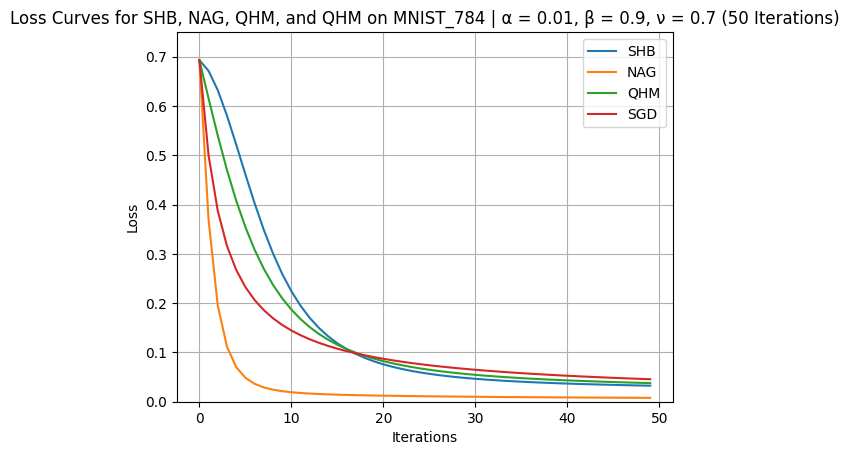

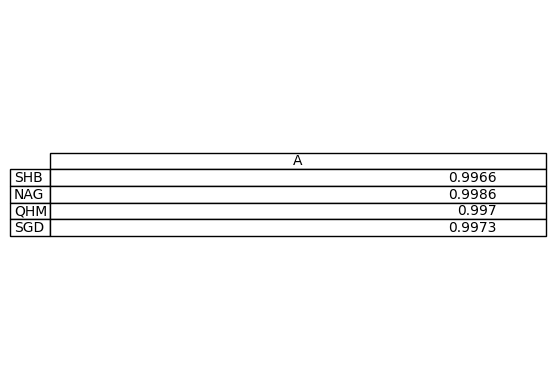

Running experiments...


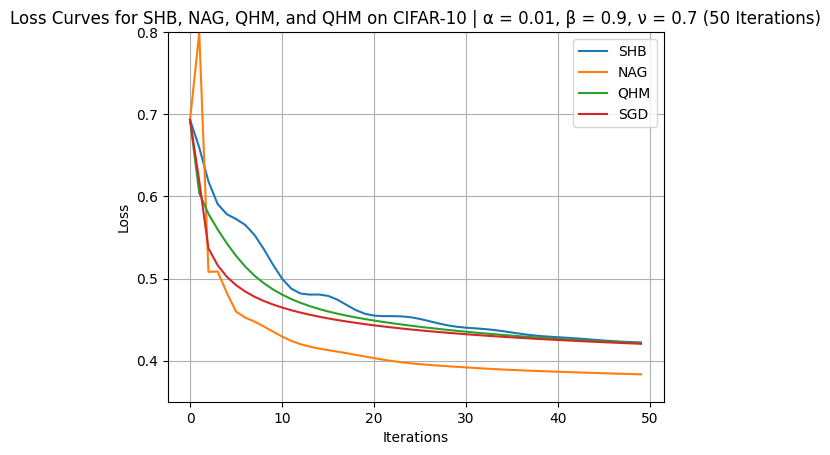

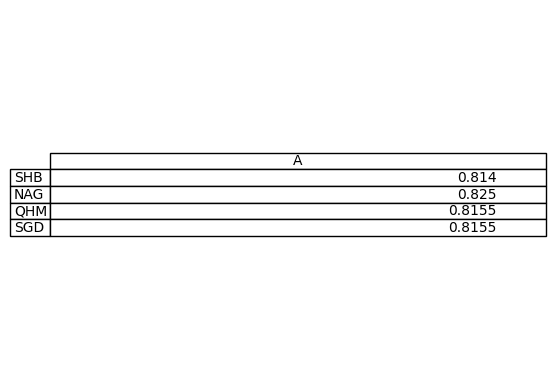

In [22]:
mnist_784.run_experiment4()
cifar_10.run_experiment4()